In [1]:
# Importam bibliotecile necesare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [2]:
dataset = pd.read_csv("master_stock.csv", index_col="Date",parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [3]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [4]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(
    figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(
    figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})",f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

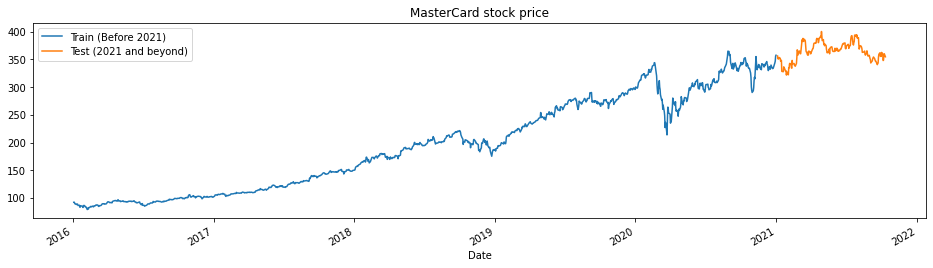

In [5]:
tstart = 2016
tend = 2020
train_test_plot(dataset,tstart,tend)

In [6]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}","High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

In [7]:
training_set, test_set = train_test_split(dataset, tstart,tend)

In [8]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [9]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
n_steps = 60
# divizăm in pasi
X_train, y_train = split_sequence(training_set_scaled,n_steps)

In [11]:
# Remodelarea X_train pentru model
features = 1
X_train.reshape(X_train.shape[0],X_train.shape[1],features)

array([[[0.04611702],
        [0.04692574],
        [0.04271097],
        ...,
        [0.03565442],
        [0.03815291],
        [0.04196816]],

       [[0.04692574],
        [0.04271097],
        [0.03589075],
        ...,
        [0.03815291],
        [0.04196816],
        [0.04456798]],

       [[0.04271097],
        [0.03589075],
        [0.03545174],
        ...,
        [0.04196816],
        [0.04456798],
        [0.04851835]],

       ...,

       [[0.91439013],
        [0.91661388],
        [0.92741912],
        ...,
        [0.89003545],
        [0.89407059],
        [0.92614221]],

       [[0.91661388],
        [0.92741912],
        [0.92147802],
        ...,
        [0.89407059],
        [0.92614221],
        [0.93713413]],

       [[0.92741912],
        [0.92147802],
        [0.9334469 ],
        ...,
        [0.92614221],
        [0.93713413],
        [0.9686838 ]]])

In [12]:
# Arhitectura
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compilarea modelului
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [13]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 3s 32ms/step - loss: 0.0157
Epoch 2/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0034
Epoch 3/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0021
Epoch 4/50
38/38 [==============================] - 1s 33ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 2s 42ms/step - loss: 0.0016
Epoch 6/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0013
Epoch 7/50
38/38 [==============================] - 2s 46ms/step - loss: 0.0012
Epoch 8/50
38/38 [==============================] - 2s 45ms/step - loss: 9.2838e-04
Epoch 9/50
38/38 [==============================] - 2s 45ms/step - loss: 0.0011
Epoch 10/50
38/38 [==============================] - 2s 49ms/step - loss: 9.5054e-04
Epoch 11/50
38/38 [==============================] - 2s 40ms/step - loss: 8.8222e-04
Epoch 12/50
38/38 [==============================] - 2s 41ms/step - loss: 7.2505e-04
Epoch 13/50
38/38 [==

In [15]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],features)

In [16]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [17]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

In [18]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

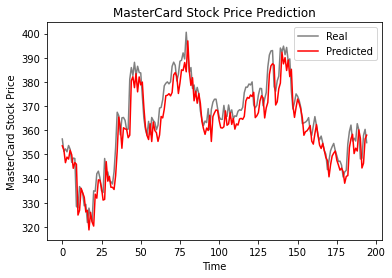

In [19]:
plot_predictions(test_set,predicted_stock_price)

In [20]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.33.
